# Brain Tumor Classification

A Brain Tumor Classifier using fine-tuned ResNet50 Neural Network architecture with almost 99 % Accuracy achieved by applying the method of Transfer Learning.

Given an MRI image of brain, classify the tumor into **Meningioma, Glioma, and Pitutary**, if present. 

Project done using Google Colab with follwing specifications:

* Ubuntu 18.04 64-bit OS
* 12 GB DDR4 RAM
* 8 GB NVidia Tesla K40 GPU
* 40 GB of Non-Persistent Storage

Refer [brain_tumor_dataset_preparation.ipynb](brain_tumor_dataset_preparation.ipynb) for dataset preparation & pre-processing that we did.

## Import Necessary Libraries

We'll be using the following libraries to complete our classification problem:

* Numpy - For linear algebra operations 
* Torch - Pytorch Deep Learning Framework
* Torch NN - Neural network class from Pytorch library
* Torch NN Functional - Functional Neural Network class from Pytorch library
* Torch Utils Data: DataLoader, Dataset - Dataset class used to create custom dataset class by subclassing it and DataLoader is used to laod data in batches using dataset class in real-time.
* Torchvision: Transforms, Models - Trochvision provides augmentation techniques using transforms class and transfer learning models are available in models class
* OS - To use Operating System methods
* Random - To set random seed at specific places where random operations take place just so it happens the same way everytime it is executed
* Pandas - To create DataFrame, CSV files, etc
* Time - To perform date time operations
* Seaborn - For sophisticated visualization
* Pickle - To save and load binary files of our training data
* Scikit-Learn - For evaluating our Classifier and for cross-validation split
* Matplotlib - To visualize images, losses and accuracy
* Google Colab Drive - To mount Google Drive so we can perform storage and loading operations using it

To install the requirements, refer [requirements.txt](requirements.txt) file

 `pip3 install -r requirements.txt`
                      
Let's go ahead and import the required libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, jaccard_similarity_score
from google.colab import drive 

Print Pytorch's version

In [0]:
torch.__version__

'1.4.0'

Import Google Drive for persistent storage of our training data, neural network model weights and other required files.

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Empty GPU's memory/cache for training so we'd clear garbage values in it and more memory will be available

In [0]:
torch.cuda.empty_cache()

## Custom Dataset Class

Create a custom dataset class that augments each image into 4 different angles: 0, 45, 90, 120, 180, 270, 300, 330 degrees. Fuse it with Pytorch's DataLoader class so data can be loaded, augmented and trained in realtime instead of caching all training samples in memory for augmenting.

In [0]:
class BrainTumorDataset(Dataset):
  def __init__(self, images, labels):
    # images
    self.X = images
    # labels
    self.y = labels
    
    # Transformation for converting original image array to an image and then convert it to a tensor
    self.transform = transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -45 degrees and 45 degrees, and then convert it to a tensor
    self.transform1 = transforms.Compose([
        transforms.ToPILImage(),                                          
        transforms.RandomRotation(45),
        transforms.ToTensor()                                  
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -90 degrees and 90 degrees, and then convert it to a tensor
    self.transform2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(90),
        transforms.ToTensor()                                  
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -120 degrees and 120 degrees, and then convert it to a tensor
    self.transform3 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(120),
        transforms.ToTensor()                                  
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -180 degrees and 180 degrees, and then convert it to a tensor
    self.transform4 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(180),
        transforms.ToTensor()                                  
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -270 degrees and 270 degrees, and then convert it to a tensor
    self.transform5 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(270),
        transforms.ToTensor()                                  
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -300 degrees and 300 degrees, and then convert it to a tensor
    self.transform6 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(300),
        transforms.ToTensor()                                  
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -330 degrees and 330 degrees, and then convert it to a tensor
    self.transform7 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(330),
        transforms.ToTensor()                                  
    ])

  def __len__(self):
    # return length of image samples
    return len(self.X)

  def __getitem__(self, idx):
    # perform transformations on one instance of X
    # Original image as a tensor
    data = self.transform(self.X[idx])

    # Augmented image at 45 degrees as a tensor
    aug45 = self.transform1(self.X[idx])

    # Augmented image at 90 degrees as a tensor
    aug90 = self.transform2(self.X[idx])

    # Augmented image at 120 degrees as a tensor
    aug120 = self.transform3(self.X[idx])

    # Augmented image at 180 degrees as a tensor
    aug180 = self.transform4(self.X[idx])

    # Augmented image at 270 degrees as a tensor
    aug270 = self.transform5(self.X[idx])

    # Augmented image at 300 degrees as a tensor
    aug300 = self.transform6(self.X[idx])

    # Augmented image at 330 degrees as a tensor
    aug330 = self.transform7(self.X[idx])      
    
    # store the transformed images in a list
    new_batch = [data, aug45, aug90, aug120, aug180, aug270, aug300, aug330]

    # convert labels to the format output by our classifier
    # 1, 2, 3 = 0, 1, 2
    # store the network's understandable label as a tensor
    labels = torch.tensor((self.y[idx]-1))

    # return the label and list of augmented images a tuple
    # 8 augmented images per sample will be returned
    return (labels, new_batch)

## Load the Dataset

* Load the **training_data.pickle** file. 

* Store the images and labels in separate lists called Xt & yt.

In [0]:
training_data = pickle.load(open('/content/drive/My Drive/Colab Notebooks/new_dataset/training_data.pickle', 'rb'))

Create empty lists for storing our data

In [0]:
Xt = []
yt = []
features = None
labels = None
label = []

Store images in Xt and labels in yt iteratively

In [0]:
for features,labels in training_data:
  Xt.append(features)
  yt.append(labels)

## Train Validation Test split

Split the dataset for training using cross-validation method.

* 70 % of images for training 
* 15% of images for validating
* 15% of images for testing

Set random seed and random_state to any arbitrary number, so the train_test_split happens the same way everytime the function is called.

In [0]:
# 70 % training, 15% validating, 15% testing
random.seed(51)
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.3, shuffle=True, random_state=33)  # 70% training, 30% testing
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=33)  # split testing set into 50% validation , 50% testing 

Empty the previously used lists and arrays to free up RAM / Cache

In [0]:
Xt = None
yt = None
features = None
labels = None
label = None
training_data = None 

Create training set, validation set and test set using our custom dataset class

In [0]:
train_set = BrainTumorDataset(X_train, y_train)
valid_set = BrainTumorDataset(X_valid, y_valid)
test_set = BrainTumorDataset(X_test, y_test)

Print original number of samples in each set

In [0]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_valid)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 2144
Number of validation samples: 460
Number of testing samples: 460


Print augmented number of samples in each set

In [0]:
print(f"Number of augmented training samples: {len(X_train) * 8}")
print(f"Number of augmented validation samples: {len(X_valid)* 8}")
print(f"Number of augmented testing samples: {len(X_test)* 8}")

Number of augmented training samples: 17152
Number of augmented validation samples: 3680
Number of augmented testing samples: 3680


Create a DataLoader for each set with batch size of 4 and shuffling enabled

In [0]:
train_gen = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
valid_gen = DataLoader(valid_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
test_gen = DataLoader(test_set, batch_size=10, shuffle=True, pin_memory=True, num_workers=8)

Get device to set the training to run on GPU or CPU later based on its availibility

In [0]:
device_name = "cuda:0:" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

## Build the Model

* Instantiate the transfer learning model using torchvision's models class.

* RESNET50 is the CNN model that we're going to use by transfer learning.

* Set all the pretrained weights to trainable by enabling every layer's parameters as true

* Build the top layer by creating a custom output sequential layer and assign it to model's fc.

In [0]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# set all paramters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.LeakyReLU(negative_slope=0.2),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.LeakyReLU(negative_slope=0.2),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 3),
                                nn.LogSoftmax(dim=1))

# set all paramters of the model as trainable
for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Set Training Configuration

* Set model's loss function as CrossEntropyLoss

* Set SGD optimizer with 0.9 momentum and learning rate 3e-4 as the model's optimizer. According to many Deep learning experts and researchers such as [Andrej karpathy](https://github.com/karpathy) 3e-4 is a good learning rate choice.

* Run the model for 10 total iterations

* Create empty lists to store training losses, validation losses, training accuracies, and validation accuracies.

In [0]:
# loss function
# if GPU is available set loss function to use GPU
if device_name=="cuda:0:":
  criterion = nn.CrossEntropyLoss().cuda()
else:
  criterion = nn.CrossEntropyLoss()  

# optimizer
optimizer = torch.optim.SGD(resnet_model.parameters(), momentum=0.9, lr=0.0003)

# number of training iterations
epochs = 10

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

## Util function

### Checkpoint Saver
A function to save the model using checkpoints based on best loss achieved during every iteration compared with previous iteration's loss. We'll load the checkpoint and resume training in case Colab's runtime get's disconnected due to inactivity or any other issues.

In [0]:
def save_checkpoint(state, is_best, filename='/content/drive/My Drive/bt_total_resnet_checkpoint.pth.tar'):
    torch.save(state, filename)

## Train the model

In [0]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_gen):
        # set label as cuda if device is cuda
        if device_name=="cuda:0:":
          y = y.cuda()

        # for images present in list of augmented images
        for images in X:
          # set image as cuda if device is cuda
          if device_name=="cuda:0:":
            images = images.cuda()

          # forward pass image sample
          y_pred = resnet_model(images)
          # calculate loss
          loss = criterion(y_pred, y)
  
          # get argmax of predicted tensor, which is our label
          predicted = torch.max(y_pred.data, 1)[1]
          # if predicted label is correct as true label, calculate the sum for samples
          batch_corr = (predicted == y).sum()
          # increment train correct with correcly predicted labels per batch
          trn_corr += batch_corr
          
          # set optimizer gradients to zero
          optimizer.zero_grad()
          # back propagate with loss
          loss.backward()
          # perform optimizer step
          optimizer.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*4}\nAccuracy: {trn_corr.item()*100/(4*8*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(valid_gen):
            # set label as cuda if device is cuda
            if device_name=="cuda:0:":            
              y = y.cuda()

            # for images present in list of augmented images
            for images in X:
                # set image as cuda if device is cuda
                if device_name=="cuda:0:":
                  images = images.cuda()
                
                # forward pass image
                y_val = resnet_model(images)

                # get argmax of predicted tensor, which is our label
                predicted = torch.max(y_val.data, 1)[1] 

                # increment test correct with correcly predicted labels per batch
                tst_corr += (predicted == y).sum()

    # get loss of validation set
    loss = criterion(y_val, y)
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(4*8*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': resnet_model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best, filename=os.path.join('/content/drive/My Drive/', 'bt_total_resnet_checkpoint_{}.pth.tar'.format(i)))

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch 2144
Accuracy: 77.87 %  Loss: 0.1423  Duration: 34.85 minutes
Validation Accuracy 87.17 Validation Loss: 0.0224

Epoch 2 Batch 2144
Accuracy: 91.30 %  Loss: 0.0766  Duration: 34.81 minutes
Validation Accuracy 90.46 Validation Loss: 0.0123

Epoch 3 Batch 2144
Accuracy: 94.04 %  Loss: 0.0156  Duration: 34.79 minutes
Validation Accuracy 89.45 Validation Loss: 0.0478

Epoch 4 Batch 2144
Accuracy: 95.85 %  Loss: 0.0030  Duration: 34.78 minutes
Validation Accuracy 95.92 Validation Loss: 1.4073

Epoch 5 Batch 2144
Accuracy: 96.97 %  Loss: 0.0019  Duration: 34.78 minutes
Validation Accuracy 97.04 Validation Loss: 0.0089

Epoch 6 Batch 2144
Accuracy: 98.55 %  Loss: 0.0354  Duration: 34.82 minutes
Validation Accuracy 94.05 Validation Loss: 1.5841

Epoch 7 Batch 2144
Accuracy: 98.53 %  Loss: 0.0008  Duration: 34.84 minutes
Validation Accuracy 91.89 Validation Loss: 0.4272

Epoch 8 Batch 2144
Accuracy: 99.16 %  Loss: 0.0002  Duration: 34.83 minutes
Validation Accuracy 97.40 Validatio

## Save the model

Save the model after the training is completed

In [0]:
torch.save(resnet_model.state_dict(), '/content/drive/My Drive/bt_total_resnet_torch.pt')

## Evaluation

Print the validation accuracy of the model calculated using validation set during training 

In [0]:
print(f'Validation accuracy: {test_correct[-1].item()*100/(test_b*8*4):.2f}%')

Validation accuracy: 98.25%


Plot the loss graph

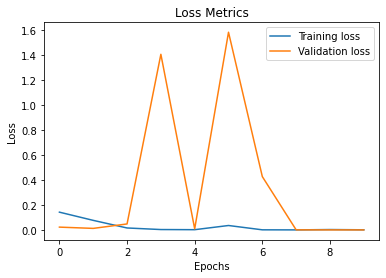

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Plot the accuracy graph

* Training set - Total length of training samples divided by 100 for every trained sample

  * `int((2144 * 8)/100) = int(171.52) = 171`

* Testing set - Total length of testing samples divided by 100 for every testing sample

  * `int((460 * 8)/100) = int(36.8) = 36`




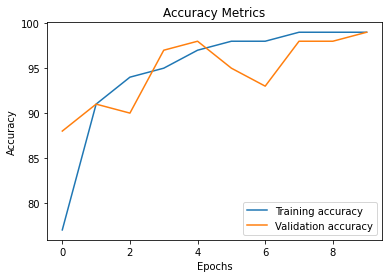

In [0]:
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Empty out training set and validation set to free up RAM / Cache

In [0]:
# resnet_model.load_state_dict(torch.load('/content/drive/My Drive/bt_resnet_torch.pt'))
train_gen = None
valid_gen = None
train_set = None
valid_set = None

Set model to evaluation mode

Calculate loss, correctly classified samples, predicted values, labels and store them in a list using test dataloader

In [0]:
# set model to evaluation mode
resnet_model.eval()

# perform no gradient updates
with torch.no_grad():
    # soem metrics storage for visualization and analysis
    correct = 0
    test_loss = []
    test_corr = []
    labels = []
    pred = []
    # perform test set evaluation batch wise
    for (y, X) in test_gen:
        # set label to use CUDA if available
        if device_name=="cuda:0:":
          y = y.cuda()

        # for images present in list of augmented images  
        for images in X:
        # set image as cuda if device is cuda
          if device_name=="cuda:0:":
            images = images.cuda()
          
          # append original labels
          labels.append(y)

          # perform forward pass
          y_val = resnet_model(images)

          # get argmax of predicted values, which is our label
          predicted = torch.max(y_val,1)[1]
          # append predicted label
          pred.append(predicted)

          # calculate loss
          loss = criterion(y_val, y)

          # increment correct with correcly predicted labels per batch
          correct += (predicted == y).sum()

          # append correct samples labels and losses
          test_corr.append(correct)
          test_loss.append(loss)
          # print(f"True: {y.cpu().numpy()}  Pred: {predicted.cpu().numpy()}")
          
print(f"Test Loss: {test_loss[-1].item():.4f}")

Test Loss: 0.0433


Print the test accuracy


In [0]:
print(f'Test accuracy: {test_corr[-1].item()*100/(460*8):.2f}%')

Test accuracy: 98.51%


Convert list of tensors to tensors

In [0]:
labels = torch.stack(labels)
pred = torch.stack(pred)

Define ground-truth labels as a list

In [0]:
LABELS = ['Meningioma', 'Glioma', 'Pitutary']

Plot the confusion matrix

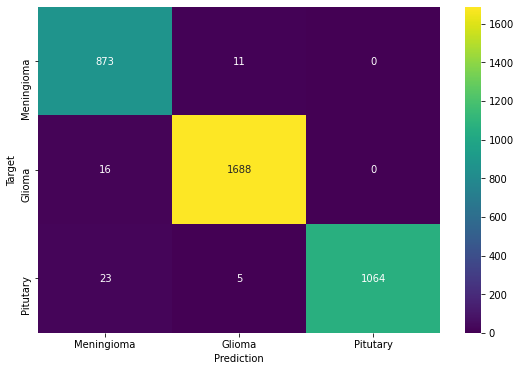

In [0]:
arr = confusion_matrix(pred.view(-1).cpu(), labels.view(-1).cpu())
df_cm = pd.DataFrame(arr, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

Print the classification report

In [0]:
print(f"Clasification Report\n\n{classification_report(pred.view(-1).cpu(), labels.view(-1).cpu())}")

Clasification Report

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       884
           1       0.99      0.99      0.99      1704
           2       1.00      0.97      0.99      1092

    accuracy                           0.99      3680
   macro avg       0.98      0.98      0.98      3680
weighted avg       0.99      0.99      0.99      3680



Print the Jaccard Similarity score / Index (Accuracy)

In [0]:
print(f"Jaccard Index\n\n{round(jaccard_similarity_score(pred.view(-1).cpu(), labels.view(-1).cpu()), 2)}")

Jaccard Index

0.99


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


We've got around 99% test accuracy which is really good. 

## Future Scopes

* The model will be deployed using python flask server as a website, so anyone could an upload MRI image of brain and find out what kinda tumor is present (if any).

* Tumor detection will be added in future to locate where the tumor is present in the given MRI image of the brain.

* Will add more sophisticated regularization techniques to prevent slight overfitting and increase accuracy upto 100 %.